In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

- fashion data cleaning/preprocessing: refer this [notebook](https://www.kaggle.com/asrsaiteja/fashion-data-cleaning)

In [2]:
file_path = '../input/fashion-data-cleaning/FashionData_Clean.csv'

In [3]:
df  = pd.read_csv(file_path, 
                  na_values = ['null', 'undefined', ''],
                 parse_dates = ['timestamp'])

In [4]:
print('Dataset has {} rows & {} columns'.format(*df.shape))
print('Column Names:', df.columns)

Dataset has 49984 rows & 16 columns
Column Names: Index(['timestamp', 'user_ID', 'ip_address', 'Product_Name', 'Product_ID',
       'Is_First_Order', 'User_Gender', 'Payment_Type', 'Number_of_Products',
       'Order_Coupon_Code', 'City', 'Country_Province', 'User_Birthday',
       'Country', 'Revenue', 'Order_Id'],
      dtype='object')


In [5]:
df = df.dropna(subset = ['Product_Name', 'Product_ID', 'Revenue']).reset_index(drop = 1)

In [6]:
print('start date:', df['timestamp'].min(), '& end date:', df['timestamp'].max())
print('Thats 21 days (3 weeks) of customer order/purchase data')

start date: 2017-10-01 00:00:23 & end date: 2017-10-21 23:59:50
Thats 21 days (3 weeks) of customer order/purchase data


In [7]:
import datetime

seg_df = df.copy()
seg_df["timestamp"] = seg_df["timestamp"].dt.date
current_date = max(seg_df.timestamp) + datetime.timedelta(days=1)

In [8]:
seg_df.shape, seg_df.columns

((49984, 16),
 Index(['timestamp', 'user_ID', 'ip_address', 'Product_Name', 'Product_ID',
        'Is_First_Order', 'User_Gender', 'Payment_Type', 'Number_of_Products',
        'Order_Coupon_Code', 'City', 'Country_Province', 'User_Birthday',
        'Country', 'Revenue', 'Order_Id'],
       dtype='object'))

- Recently: How recently user palced order (lower is better).
- Frequency: How frequently user placed orders (higher is better).
- Revenue: How much did user spend on his orders (higher is better).

In [9]:
# Aggregate data by each customer
seg_df = seg_df.groupby(['user_ID']).agg({
    'timestamp': lambda x: (current_date - x.max()).days, # recency
    'user_ID': 'count', # frequency
    'Revenue': 'sum'}) # monetary value

In [10]:
seg_df.head()

,timestamp,user_ID,Revenue
user_ID,,,
0,1,121,18463.44
1,19,1,113.55
2,8,1,81.78
3,18,1,63.63
4,14,1,81.77


In [11]:
seg_df_index = seg_df.index
seg_df.reset_index(drop = True, inplace = True)
seg_df.rename(columns = {'timestamp': 'Recency',
                         'user_ID': 'Frequency','Revenue': 'MonetaryValue'}, inplace=True)
seg_df['user_ID'] = seg_df_index

In [12]:
seg_df.describe()

,Recency,Frequency,MonetaryValue,user_ID
count,44089.000000,44089.000000,44089.000000,44089.000000
mean,11.181678,1.133707,151.961798,22052.291864
std,5.788085,0.958502,184.498092,12732.300062
min,1.000000,1.000000,0.000000,0.000000
25%,6.000000,1.000000,64.730000,11027.000000
50%,11.000000,1.000000,108.180000,22054.000000
75%,17.000000,1.000000,181.640000,33078.000000
max,21.000000,121.000000,18463.440000,44103.000000


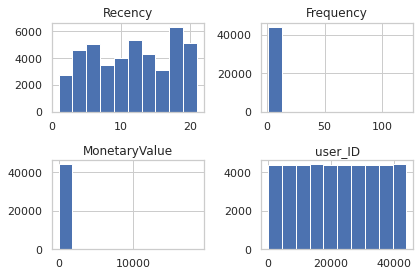

In [13]:
seg_df.hist()
plt.tight_layout()

- Data points are skewed.
- Frequency: transform using boxcox to balance the skewness.
- Monetary Value: As this is revenue, the values will be comparatively high so taking square/cube root will improve the distribution. (making the values closer)

In [14]:
# plt.hist(stats.boxcox(df_seg['Frequency'], lmbda = 0.5)[0])

In [15]:
from scipy import stats
seg_norm_df = seg_df.drop(['user_ID'], axis = 1)
seg_norm_df["Recency"] = stats.boxcox(seg_df['Recency'])[0]
seg_norm_df["Frequency"] = stats.boxcox(seg_df['Frequency'])[0]
seg_norm_df["MonetaryValue"] = pd.Series(np.cbrt(seg_df['MonetaryValue'] + 0.001)).values

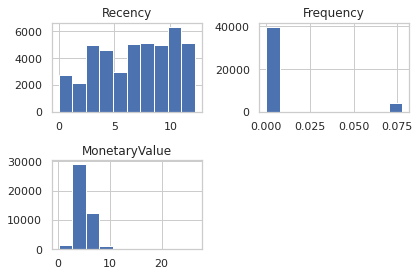

In [16]:
seg_norm_df.hist()
plt.tight_layout()

In [17]:
from sklearn.preprocessing import MinMaxScaler
# Alternate: StandardScaler, used MinMaxScaler to avoid -ve values.
scaler = MinMaxScaler()
scaler.fit(seg_norm_df)
seg_norm = scaler.transform(seg_norm_df)

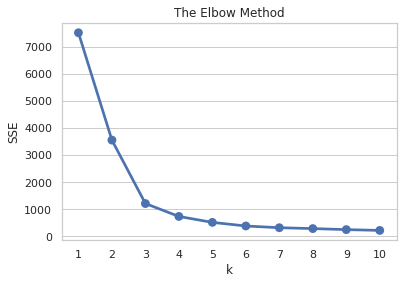

In [18]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=2021)
    kmeans.fit(seg_norm)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

- Elbow Plot -> 3 clusters/
- After 3 clusters, the difference in sse is linear/nearly same.

In [19]:
model = KMeans(n_clusters=3, random_state=2021)
model.fit(seg_norm)
model.labels_.shape


(44089,)

In [20]:
result_df = pd.DataFrame(seg_norm, columns = ['Recency', 'Frequency', 'MonetaryValue'])
result_df["Cluster"] = model.labels_
result_df.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':'mean'}).round(3)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,0.290,0.0,0.177
1,0.780,0.0,0.175
2,0.448,1.0,0.241


- Cluster 0 : **New Customers**, As recency is high (ordered longback) & contribution to revenue is less.
- Cluster 1: **Churned Customers**, As recency is low (ordered recently) & contribution to revenue is reasonable.
- Cluster 2: **Loyal Customers**, As order frequency is high (ordered frequently) & contribution to revenue is high.

In [21]:
# Melt The Data
result_melt = pd.melt(result_df.reset_index(),
        id_vars=['index', 'Cluster'],
        value_vars=['Recency','Frequency','MonetaryValue'],
        var_name='Attribute',
        value_name='Value')
result_melt.shape

(132267, 4)

In [22]:
result_melt['Cluster'].replace({0: 'New', 1:'Churned', 2:'Loyal'}, inplace = True)

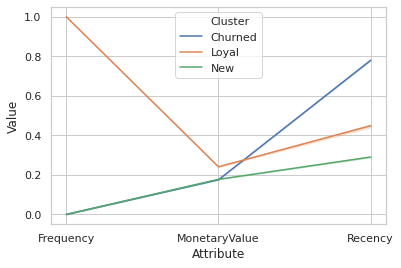

In [23]:
# Visualize it
# sns.set(style="whitegrid")
sns.lineplot('Attribute', 'Value', hue='Cluster', 
             data=result_melt.sort_values(by = 'Cluster'),
             palette=None)

In [24]:
seg_df['Customer_Type'] = result_melt['Cluster']
seg_df['Customer_Type'] .value_counts()

Churned    22540
New        17238
Loyal       4311
Name: Customer_Type, dtype: int64

In [25]:
segments = seg_df.groupby('Customer_Type').agg(num_customers = ('Customer_Type', 'count'),
                                    num_orders =('Frequency', 'sum'),
                                    avg_order_freq =('Frequency', 'mean'),
                                    avg_order_recency =('Recency', 'mean'),
                                    avg_revenue =('MonetaryValue', 'mean')
                                              ).sort_index()
segments

,num_customers,num_orders,avg_order_freq,avg_order_recency,avg_revenue
Customer_Type,,,,,
Churned,22540,22540,1.000000,15.805413,130.618210
Loyal,4311,10206,2.367432,8.932962,327.981923
New,17238,17238,1.000000,5.698167,135.849820


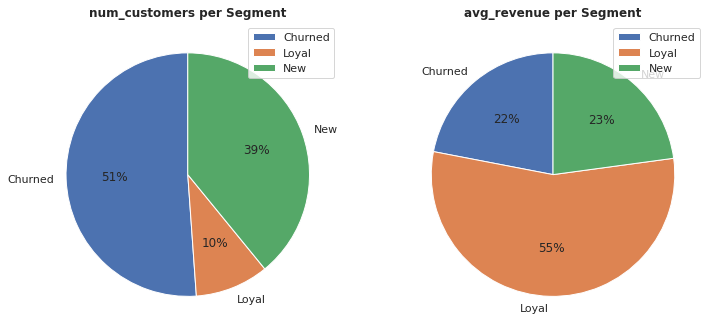

In [26]:
fig, ax = plt.subplots(1,2, figsize=(12,12))
ax = ax.flatten()
for i,cat in enumerate(['num_customers', 'avg_revenue']):
    segments.plot(ax=ax[i], y = cat, kind='pie', 
                   autopct='%1.f%%', startangle=90, legend = True, ylabel = '')
    ax[i].set_ylabel('')
    ax[i].set_title(f"{cat} per Segment", fontweight='bold')

In [27]:
seg_df.to_csv('FashionData_Segmented.csv', index = False)
seg_df.shape, seg_df.columns

((44089, 5),
 Index(['Recency', 'Frequency', 'MonetaryValue', 'user_ID', 'Customer_Type'], dtype='object'))